**Import Libraries and packages**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display # Allows the use of display() for DataFrames

# Control the default size of figures in this Jupyter notebook
%pylab inline

# Pretty display for notebooks
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from pandas import concat
from pandas_datareader import data
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation

# set random seed
numpy.random.seed(7)

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


**Import dataset**

In [2]:
# Load the dataset
# Stocks from Computer hardware Computer software Consumer electronics, Financial services,Automotive Energy storage

# load Apple Inc. dataset
aapl_data = data.DataReader('aapl', start=datetime.date.today().year - 5, end=datetime.date.today().year + 1,
                       data_source='yahoo')
# load VISA Inc. dataset
visa_data = data.DataReader('v', start=datetime.date.today().year - 5, end=datetime.date.today().year + 1,
                       data_source='yahoo')
# load Tesla Inc. dataset
tesla_data = data.DataReader('tsla', start=datetime.date.today().year - 5, end=datetime.date.today().year + 1,
                       data_source='yahoo')

**Data Exploration and Visualization**

In [18]:
aapl_data.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1497 entries, 2013-01-02 to 2018-12-11
Data columns (total 6 columns):
High         1497 non-null float64
Low          1497 non-null float64
Open         1497 non-null float64
Close        1497 non-null float64
Volume       1497 non-null float64
Adj Close    1497 non-null float64
dtypes: float64(6)
memory usage: 81.9 KB


Text(0,0.5,'Adj Close in USD')

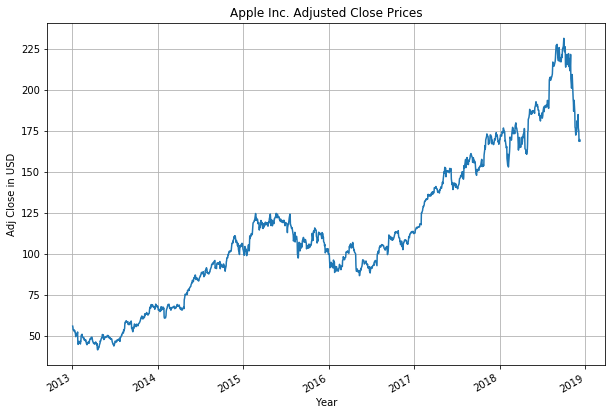

In [3]:
# Plot Apple Inc. Adjusted Price
fig, ax = plt.subplots( nrows=1, ncols=1 )
fig.set_size_inches(10, 7)
aapl_data['Adj Close'].plot(ax = ax, title = "Apple Inc. Adjusted Close Prices", grid=True)
ax.set_xlabel("Year")
ax.set_ylabel("Adj Close in USD")

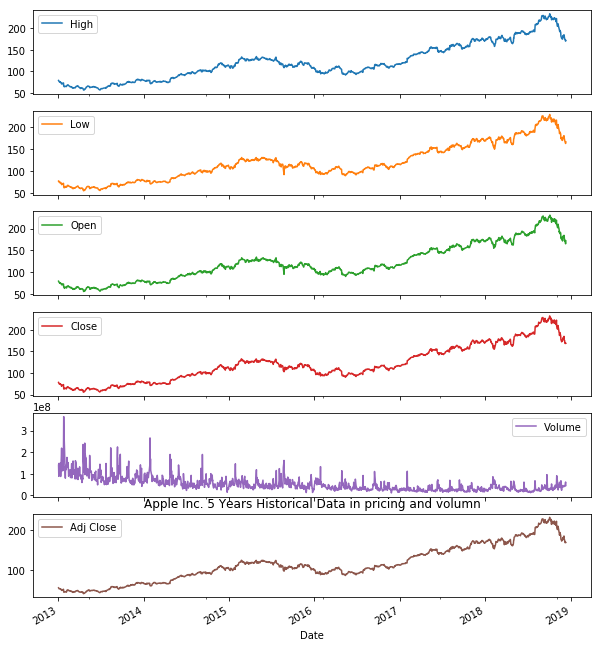

In [4]:
aapl_data.plot(subplots=True, figsize=(10,12))
plt.title('Apple Inc. 5 Years Historical Data in pricing and volumn')
plt.show()

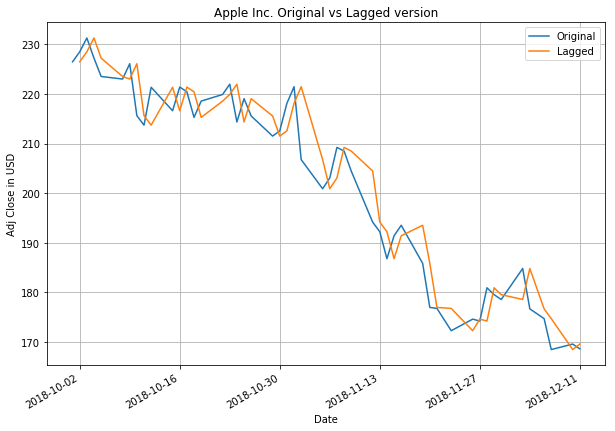

In [5]:
# Plot Apple Inc. 50 days Adjusted Closing Price and same set with 1 day lagged version
fig, ax = plt.subplots( nrows=1, ncols=1 )
fig.set_size_inches(10, 7)
trimmed_aapl = aapl_data['Adj Close'].tail(50)
trimmed_aapl.plot(ax = ax, title = "Apple Inc. Original vs Lagged version", grid=True)
shifted = trimmed_aapl.shift(1).plot(legend=True, grid=True)
shifted.legend(['Original','Lagged'])
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close in USD")
plt.show()

**Benchmark model (Benchmark Model 1, Linear Regression > Benchmark Model 2, Persistence Model)**

Apple RMSE score of Linear Regression is 2.549, and Persistence Model is 2.545


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


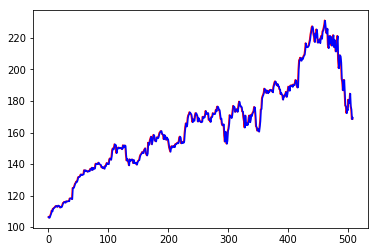

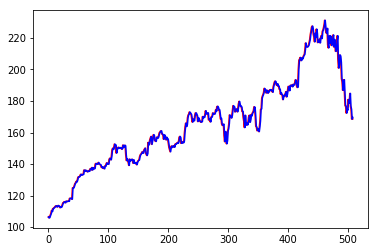

VISA RMSE score of Linear Regression is 1.504, and Persistence Model is 1.494


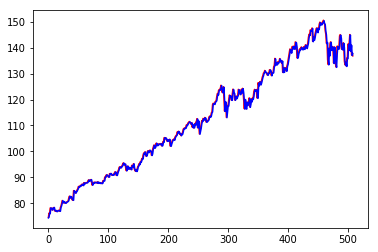

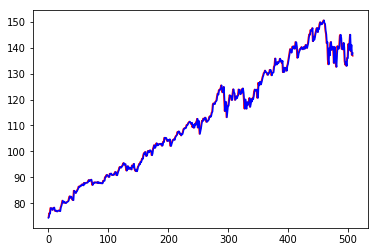

TESLA RMSE score of Linear Regression is 9.030, and Persistence Model is 9.012


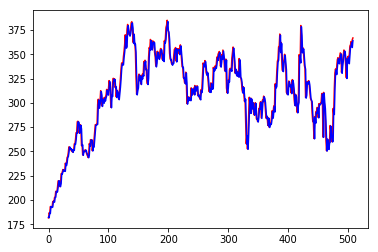

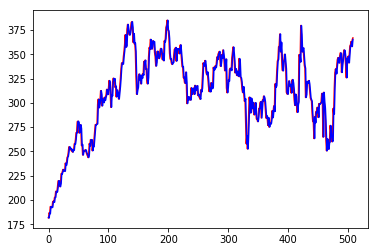

In [6]:
# Calculate RMSE of benchmark models
def get_benchmark(ds, title):
    # Get dataset with only Adj Close column
    ds = ds['Adj Close']

    # dataset shift by 1 day, creating x and y
    ds = concat([ds.shift(1), ds], axis=1).dropna()

    # train and test split
    ds = ds.values

    # getting the X input and y label
    X, y = ds[:,0], ds[:,1]

    # using train_test_split func to split X and Y into their train and test sets
    train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=int(len(ds) * 0.66), shuffle=False, random_state=7)
    
    # benchmark model 1, linear regression
    # init linear regression model
    linearreg_model = LinearRegression()

    # fit the model with training data
    linearreg_model.fit(train_X.reshape(-1, 1), train_y)

    # make prediction using linear regression model
    lin_preds = linearreg_model.predict(test_X.reshape(-1, 1))
    
    # benchmark model 2, Persistence model
    # create persistence model result
    pers_preds = [y for y in test_X]

    # calculate the RMSE score and print it
    lin_rmse_score = sqrt(mean_squared_error(test_y, lin_preds))
    pers_rmse_score = sqrt(mean_squared_error(test_y, pers_preds))
    print(title + ' RMSE score of Linear Regression is %.3f, and Persistence Model is %.3f' % (lin_rmse_score,pers_rmse_score))
    # plot actual y value and predicted y value
    pyplot.plot(test_y, color='red')
    pyplot.plot(lin_preds, color='blue')
    pyplot.show()
    pyplot.plot(test_y, color='red')
    pyplot.plot(pers_preds, color='blue')
    pyplot.show()
    return [lin_rmse_score,pers_rmse_score]

aapl_benchmark_scores = get_benchmark(aapl_data, 'Apple')
visa_benchmark_scores = get_benchmark(visa_data, 'VISA')
tesla_benchmark_scores = get_benchmark(tesla_data, 'TESLA')

**Model Training and Testing**

**XGBRegressor**

Apple RMSE score of test is 2.577


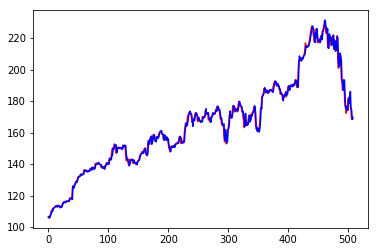

VISA RMSE score of test is 1.501


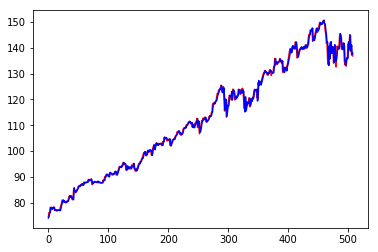

TESLA RMSE score of test is 9.224


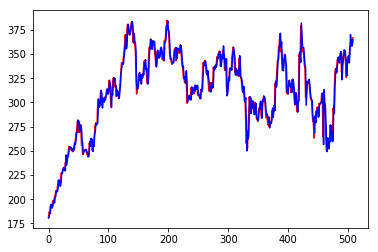

In [7]:
# function to unscale and undiff the data
def inverse_transform(predictions, test_withscale, scaler, original_test_y):
    final_predictions = list()
    for i in range(len(predictions)):
        full_pred = numpy.array([test_withscale[i, 0:-1]] + [predictions[i]])
        # invert scaling
        unscaled_output = scaler.inverse_transform(full_pred.reshape(1, len(full_pred)))
        # invert differencing
        undiff_output = unscaled_output[0, -1] + original_test_y[-(len(test_withscale)+1-i)]

        # store forecast
        final_predictions.append(undiff_output)
    return final_predictions

# function will fit and predict on the provided dataset using XGBRegressor model
def get_xgbreg_score(ds, title):
    # Get dataset with only Adj Close col
    ds_data = ds['Adj Close']

    # transform data to be stationary by calculate the difference by 1 days
    ds_diff = ds['Adj Close'].diff(1).dropna()

    # transform data to be supervised learning
    ds_lagged = concat([ds_diff.shift(1), ds_diff], axis=1).dropna()
    ds_lagged = ds_lagged.values

    # split lagged dataset into training and testing splits
    training_size = int(len(ds_lagged) * 0.66)
    train, test = ds_lagged[:training_size], ds_lagged[training_size:]

    # scale the train and test sets
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train_withscale = scaler.transform(train)
    test_withscale = scaler.transform(test)

    # split the train and test into their X and Y sets
    train_X, test_X, train_y, test_y = train_withscale[:,0], test_withscale[:,0], train_withscale[:,1], test_withscale[:,1] 

    # original test set with no scaling and diff
    original_test = concat([ds_data.shift(1), ds_data], axis=1).dropna().values
    original_test_y = original_test[:,1]
    original_test_y = original_test_y[training_size:]
    
    # Init XGB Regressor Model
    xgb_model = XGBRegressor()

    # Train and predict
    # fit xgbregressor model
    xgb_model.fit(train_X.reshape(-1, 1), train_y)

    # make prediction using the xgbregressor model
    predictions = xgb_model.predict(test_X.reshape(-1, 1))

    # inverse transformation on data
    recov_preds = inverse_transform(predictions, test_withscale, scaler, original_test_y)

    # calculate RMSE score
    rmse_score = sqrt(mean_squared_error(original_test_y[1:], recov_preds))
    print(title + ' RMSE score of test is %.3f' % rmse_score)
    # plot actual y value and predicted y value
    pyplot.plot(original_test_y[1:], color='red')
    pyplot.plot(recov_preds, color='blue')
    pyplot.show()
    return rmse_score

aapl_xgb_scores = get_xgbreg_score(aapl_data, 'Apple')
visa_xgb_scores = get_xgbreg_score(visa_data, 'VISA')
tesla_xgb_scores = get_xgbreg_score(tesla_data, 'TESLA')

**Tuning and improve**

-0.00037257278444259497
{'colsample_bytree': 0.2, 'gamma': 0, 'learning_rate': 0.08, 'max_depth': 1, 'min_child_weight': 0, 'n_estimators': 50, 'silent': 1, 'subsample': 0.2}
Apple RMSE score of test is 2.545


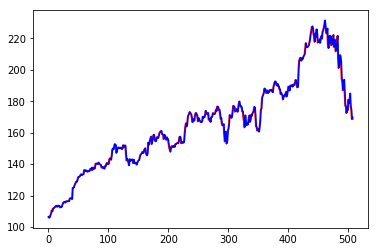

0.0011562113887764293
{'colsample_bytree': 0.2, 'gamma': 0, 'learning_rate': 0.06, 'max_depth': 1, 'min_child_weight': 4, 'n_estimators': 50, 'silent': 1, 'subsample': 0.2}
VISA RMSE score of test is 1.485


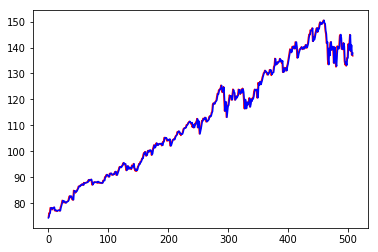

0.002034178188830652
{'colsample_bytree': 0.2, 'gamma': 0, 'learning_rate': 0.08, 'max_depth': 2, 'min_child_weight': 0, 'n_estimators': 5, 'silent': 1, 'subsample': 0.1}
TESLA RMSE score of test is 9.013


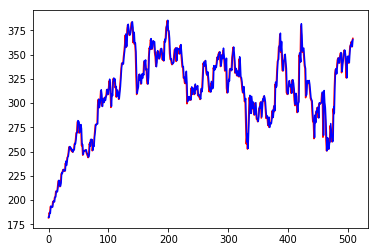

In [8]:
# function will fit and predict on the provided dataset using XGBRegressor model
def get_imp_xgbreg_score(ds, title):
    # Get dataset with only Adj Close col
    ds_data = ds['Adj Close']

    # transform data to be stationary by calculate the difference by 1 days
    ds_diff = ds['Adj Close'].diff(1).dropna()

    # transform data to be supervised learning
    ds_lagged = concat([ds_diff.shift(1), ds_diff], axis=1).dropna()
    ds_lagged = ds_lagged.values
    
    # get the lagged version X and Y columns
    X,y = ds_lagged[:,0], ds_lagged[:,1]

    # init XGB Regressor Model
    xgb_model = XGBRegressor()

    # define testing parameters for GridSearchCV
    parameters = {'learning_rate': [.04, .06, .08, .1],
                  'colsample_bytree': [.2, .4, .6],
                  'subsample': [.1, .2, .4],
                  'n_estimators': [5, 25, 50, 100],
                  'max_depth': range(1,3),
                  'min_child_weight': [0, 1, 4],
                  'gamma': [0],
                  'silent': [1]}

    # define GridSearchCV
    imp_xgb_model = GridSearchCV(estimator=xgb_model, param_grid=parameters, verbose=False, n_jobs=2)
    
    # fit the model and output the findings
    imp_xgb_model.fit(X.reshape(-1, 1), y)
    print(imp_xgb_model.best_score_)
    print(imp_xgb_model.best_params_)

    # split lagged dataset into training and testing splits
    training_size = int(len(ds_lagged) * 0.66)
    train, test = ds_lagged[:training_size], ds_lagged[training_size:]

    # scale the train and test sets
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train_withscale = scaler.transform(train)
    test_withscale = scaler.transform(test)

    # split the train and test into their X and Y sets
    train_X, test_X, train_y, test_y = train_withscale[:,0], test_withscale[:,0], train_withscale[:,1], test_withscale[:,1] 

    # original test set with no scaling and diff
    original_test = concat([ds_data.shift(1), ds_data], axis=1).dropna().values
    original_test_y = original_test[:,1]
    original_test_y = original_test_y[training_size:]
    
    # fit the improved xgbregressor model 
    imp_xgb_model.fit(train_X.reshape(-1, 1), train_y)

    # make prediction using the improved model
    predictions = imp_xgb_model.predict(test_X.reshape(-1, 1))

    # inverse transformation on data
    recov_preds = inverse_transform(predictions, test_withscale, scaler, original_test_y)

    # calculate RMSE score
    rmse_score = sqrt(mean_squared_error(original_test_y[1:], recov_preds))
    print(title + ' RMSE score of test is %.3f' % rmse_score)
    # plot actual y value and predicted y value
    pyplot.plot(original_test_y[1:], color='red')
    pyplot.plot(recov_preds, color='blue')
    pyplot.show()
    return rmse_score

aapl_xgb_scores = get_imp_xgbreg_score(aapl_data, 'Apple')
visa_xgb_scores = get_imp_xgbreg_score(visa_data, 'VISA')
tesla_xgb_scores = get_imp_xgbreg_score(tesla_data, 'TESLA')

**RNN LSTM**

Epoch 1/1
 - 8s - loss: 0.0510
Apple RMSE score of test is 2.558


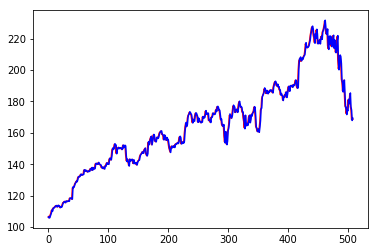

Epoch 1/1
 - 6s - loss: 0.0359
VISA RMSE score of test is 1.520


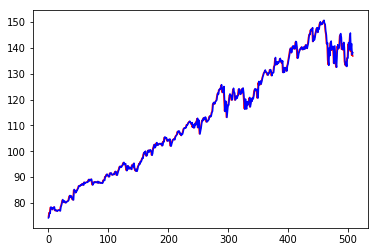

Epoch 1/1
 - 6s - loss: 0.0396
TESLA RMSE score of test is 9.036


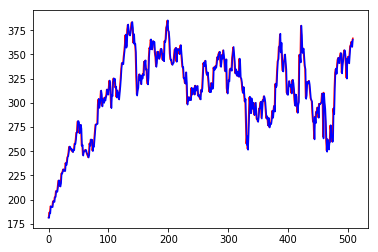

In [9]:
# function will fit and predict on the provided dataset using XGBRegressor model
def get_lstm_score(ds, title):
    # Get dataset with only Adj Close col
    ds_data = ds['Adj Close']

    # transform data to be stationary by calculate the difference by 1 days
    ds_diff = ds['Adj Close'].diff(1).dropna()

    # transform data to be supervised learning
    ds_lagged = concat([ds_diff.shift(1), ds_diff], axis=1).dropna()
    ds_lagged = ds_lagged.values

    # split lagged dataset into training and testing splits
    training_size = int(len(ds_lagged) * 0.66)
    train, test = ds_lagged[:training_size], ds_lagged[training_size:]

    # scale the train and test sets
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train_withscale = scaler.transform(train)
    test_withscale = scaler.transform(test)

    # original test set with no scaling and diff
    original_test = concat([ds_data.shift(1), ds_data], axis=1).dropna().values
    original_test_y = original_test[:,1]
    original_test_y = original_test_y[training_size:]
    
    # parameters for the LSTM Model, with all value of 1 to begin with
    batch_size, neurons, epochs = 1,1,1

    # get X and Y values
    X, y = train_withscale[:, 0:-1], train_withscale[:, -1]

    # reshape X for LSTM batch shape
    X = X.reshape(X.shape[0], 1, X.shape[1])

    # Init LSTM Model
    lstm_model = Sequential()
    lstm_model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    lstm_model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)
    
    # make prediction using lstm_model
    X = test_withscale[:, 0:-1]
    predictions = lstm_model.predict(X.reshape(X.shape[0], 1, X.shape[1]), batch_size=batch_size)

    # inverse transformation on data
    recov_preds = inverse_transform(predictions, test_withscale, scaler, original_test_y)

    # calculate RMSE score
    rmse_score = sqrt(mean_squared_error(original_test_y[1:], recov_preds))
    print(title + ' RMSE score of test is %.3f' % rmse_score)
    # plot actual y value and predicted y value
    pyplot.plot(original_test_y[1:], color='red')
    pyplot.plot(recov_preds, color='blue')
    pyplot.show()
    return rmse_score

aapl_lstm_scores = get_lstm_score(aapl_data, 'Apple')
visa_lstm_scores = get_lstm_score(visa_data, 'VISA')
tesla_lstm_scores = get_lstm_score(tesla_data, 'TESLA')

**Tuning and Improve**

In [10]:
# function will fit and predict on the provided dataset using XGBRegressor model
def get_imp_lstm_score(ds, title):    
    # Get dataset with only Adj Close col
    ds_data = ds['Adj Close']

    # transform data to be stationary by calculate the difference by 1 days
    ds_diff = ds['Adj Close'].diff(1).dropna()

    # transform data to be supervised learning
    ds_lagged = concat([ds_diff.shift(1), ds_diff], axis=1).dropna()
    ds_lagged = ds_lagged.values

    # split lagged dataset into training and testing splits
    training_size = int(len(ds_lagged) * 0.66)
    train, test = ds_lagged[:training_size], ds_lagged[training_size:]

    # scale the train and test sets
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train_withscale = scaler.transform(train)
    test_withscale = scaler.transform(test)

    # original test set with no scaling and diff
    original_test = concat([ds_data.shift(1), ds_data], axis=1).dropna().values
    original_test_y = original_test[:,1]
    original_test_y = original_test_y[training_size:]

    # get X and Y values
    X, y = train_withscale[:, 0:-1], train_withscale[:, -1]

    # reshape X for LSTM batch shape
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    # init parameters
    batch_size, neurons, epochs = 1,1,1

    # combo testing parameters
    bz = [1,2]
    ne = [15,16,23]
    ep = [1,5,7]

    pars = list()
    for b in bz:
        for n in ne:
            for e in ep:
                pars.append([b,n,e])

    best_rmse = np.inf
    best_rmse_parms = [0,0,0]
    
    for parstuple in pars:
        # parameters
        batch_size, neurons, epochs = parstuple[0],parstuple[1],parstuple[2]

        # get X and Y values
        X, y = train_withscale[:, 0:-1], train_withscale[:, -1]

        # reshape X for LSTM batch shape
        X = X.reshape(X.shape[0], 1, X.shape[1])

        # Init LSTM Model
        lstm = Sequential()
        lstm.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
        lstm.add(Dense(1))
        lstm.compile(loss='mean_squared_error', optimizer='adam')
        lstm.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)

        try:
            # make prediction using lstm
            X = test_withscale[:, 0:-1]
            predictions = lstm.predict(X.reshape(X.shape[0], 1, X.shape[1]), batch_size=batch_size)

            # inverse transformation on data
            recov_preds = inverse_transform(predictions, test_withscale, scaler, original_test_y)

            # calculate RMSE score
            rmse_score = sqrt(mean_squared_error(original_test_y[1:], recov_preds))
            if best_rmse > rmse_score:
                best_rmse = rmse_score
                best_rmse_parms = parstuple
        except ValueError:
            print('Parameter not correct')
    
    print(title + ' Best RMSE score of test is %.3f' % best_rmse)        
    return [best_rmse, best_rmse_parms]

aapl_imp_lstm_scores = get_imp_lstm_score(aapl_data, 'Apple')
visa_imp_lstm_scores = get_imp_lstm_score(visa_data, 'VISA')
tesla_imp_lstm_scores = get_imp_lstm_score(tesla_data, 'TESLA')

Parameter not correct
Parameter not correct
Parameter not correct
Parameter not correct
Parameter not correct
Parameter not correct
Parameter not correct
Parameter not correct
Parameter not correct
Apple Best RMSE score of test is 2.543
Parameter not correct
Parameter not correct
Parameter not correct
Parameter not correct
Parameter not correct
Parameter not correct
Parameter not correct
Parameter not correct
Parameter not correct
VISA Best RMSE score of test is 1.480
Parameter not correct
Parameter not correct
Parameter not correct
Parameter not correct
Parameter not correct
Parameter not correct
Parameter not correct
Parameter not correct
Parameter not correct
TESLA Best RMSE score of test is 9.044


In [16]:
print('Apple RMSE score is %.3f' % aapl_imp_lstm_scores[0])
print('With parameters of: batch_size=%.d, neurons=%.d, epoch=%.d' % (aapl_imp_lstm_scores[1][0], aapl_imp_lstm_scores[1][1], aapl_imp_lstm_scores[1][2]))

print('VISA RMSE score is %.3f' % visa_imp_lstm_scores[0])
print('With parameters of: batch_size=%.d, neurons=%.d, epoch=%.d' % (visa_imp_lstm_scores[1][0], visa_imp_lstm_scores[1][1], visa_imp_lstm_scores[1][2]))

print('TESLA RMSE score is %.3f' % tesla_imp_lstm_scores[0])
print('With parameters of: batch_size=%.d, neurons=%.d, epoch=%.d' % (tesla_imp_lstm_scores[1][0], tesla_imp_lstm_scores[1][1], tesla_imp_lstm_scores[1][2]))


Apple RMSE score is 2.543
With parameters of: batch_size=1, neurons=23, epoch=1
VISA RMSE score is 1.480
With parameters of: batch_size=1, neurons=23, epoch=7
TESLA RMSE score is 9.044
With parameters of: batch_size=1, neurons=16, epoch=5


**END**